In [1]:
!pip install pandas_ta

In [2]:
!pip install pandas_ta FinanceDataReader

ERROR: Could not find a version that satisfies the requirement FinanceDataReader (from versions: none)
ERROR: No matching distribution found for FinanceDataReader


In [3]:
import torch
import numpy as np
import pandas as pd
from torch import nn
from torch.utils.data import DataLoader, TensorDataset
import pandas_ta as ta
from sklearn.preprocessing import MinMaxScaler
import FinanceDataReader as fdr

In [4]:
# 하이퍼파라미터
FEATURE_NUMS = 12  # 'Close'를 제외한 피처 수
SEQ_LENGTH = 5
HIDDEN_SIZE = 64
NUM_LAYERS = 2
LEARNING_RATE = 1e-3
BATCH_SIZE = 32
EPOCHS = 200
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [5]:
# 삼성전자 주가 데이터 로드
df = fdr.DataReader('005930', '2022-09-30')
df.reset_index(inplace=True)
df.set_index('Date', inplace=True)

In [6]:
# KOSPI 200 지수 및 환율 데이터 로드
kospi200 = pd.read_csv('KOSPI 200 Index_20240927.csv', encoding='utf-8', parse_dates=['Date'])
kospi200.set_index('Date', inplace=True)
exchange_rate = pd.read_csv('USD_KRW 과거 데이터_20240927.csv', encoding='utf-8', parse_dates=['Date'])
exchange_rate.set_index('Date', inplace=True)

# '외국인 합계' 데이터 로드
foreign_data = pd.read_csv('투자자별 거래실적_20240927.csv', encoding='utf-8', parse_dates=['Date'])
foreign_data.set_index('Date', inplace=True)

In [7]:
# KOSPI 200 지수 데이터 확인
print("KOSPI 200 지수 데이터:")
display(kospi200.head())  
display(kospi200.tail())

# 환율 데이터 확인
print("\n환율 데이터:")
display(exchange_rate.head())
display(exchange_rate.tail())

# '외국인 합계' 데이터 확인
print("\n외국인 합계 데이터:")
display(foreign_data.head())
display(foreign_data.tail())

KOSPI 200 지수 데이터:


,KOSPI200,대비,등락률,시가,고가,저가,거래량,거래대금,상장시가총액
Date,,,,,,,,,
2024-09-27,353.93,-2.51,-0.70,356.93,358.71,353.93,"138,011","9,458,827","1,903,422,343"
2024-09-26,356.44,11.88,3.45,350.68,356.44,350.44,"139,542","10,265,319","1,920,138,987"
2024-09-25,344.56,-5.05,-1.44,352.51,354.09,344.56,"156,600","9,879,019","1,863,519,756"
2024-09-24,349.61,3.83,1.11,347.19,349.61,344.75,"122,751","8,963,484","1,889,818,953"
2024-09-23,345.78,1.11,0.32,345.01,346.14,343.67,"116,062","7,785,096","1,867,137,908"


,KOSPI200,대비,등락률,시가,고가,저가,거래량,거래대금,상장시가총액
Date,,,,,,,,,
2022-10-07,290.41,-0.85,-0.29,288.35,292.20,287.84,"128,156","6,006,691","1,539,001,559"
2022-10-06,291.26,2.21,0.76,291.20,293.32,290.09,"93,858","5,017,652","1,542,172,687"
2022-10-05,289.05,0.78,0.27,293.87,294.47,287.44,"138,907","7,289,051","1,528,199,265"
2022-10-04,288.27,6.91,2.46,286.25,288.96,285.42,"120,019","6,053,599","1,522,328,611"
2022-09-30,281.36,-1.29,-0.46,281.75,284.35,278.39,"143,738","6,233,068","1,485,351,846"



환율 데이터:


,환율,시가,고가,저가,거래량,변동 %
Date,,,,,,
2024-09-27,1315,1314,1323,1314,NaN,0.14%
2024-09-26,1313,1336,1337,1313,NaN,-1.56%
2024-09-25,1334,1326,1339,1323,NaN,0.63%
2024-09-24,1325,1334,1339,1325,NaN,-0.63%
2024-09-23,1334,1333,1340,1332,NaN,0.15%


,환율,시가,고가,저가,거래량,변동 %
Date,,,,,,
2022-10-06,1408,1417,1418,1397,NaN,-0.52%
2022-10-05,1416,1416,1424,1410,NaN,0.01%
2022-10-04,1416,1433,1437,1416,NaN,-1.25%
2022-10-03,1433,1440,1446,1434,NaN,-0.45%
2022-09-30,1440,1430,1442,1428,NaN,0.70%



외국인 합계 데이터:


,기관 합계,기타법인,개인,외국인 합계,전체
Date,,,,,
2024-09-27,1106122,228271,2927084,1592691,0
2024-09-26,4782001,34154,1089991,3726164,0
2024-09-25,3172763,198047,5389240,8760050,0
2024-09-24,2828093,40895,4710430,7579418,0
2024-09-23,1860477,44424,8197566,10102467,0


,기관 합계,기타법인,개인,외국인 합계,전체
Date,,,,,
2022-10-07,361472,52411,1050813,1464696,0
2022-10-06,479637,76899,1325116,1881652,0
2022-10-05,2444114,32679,1539352,3950787,0
2022-10-04,285415,41214,4066209,4392838,0
2022-09-30,584406,3502,1863241,1275333,0


In [8]:
# 데이터 병합
df = df.merge(foreign_data[['외국인 합계']], left_index=True, right_index=True, how='left')
df = df.merge(kospi200[['KOSPI200']], left_index=True, right_index=True, how='left')
df = df.merge(exchange_rate[['환율']], left_index=True, right_index=True, how='left')

In [9]:
# 기술적 지표 추가 (일목균형표 선행스팬, 볼린저밴드 상한선과 하한선, RSI)
df['RSI'] = df.ta.rsi(length=14)

# 일목균형표 (ichimoku)
ichimoku = df.ta.ichimoku()
df['Leading_Span_A'] = ichimoku[0]['ISA_9']  # 일목균형표 선행스팬 A
df['Leading_Span_B'] = ichimoku[0]['ISB_26']  # 일목균형표 선행스팬 B

# 볼린저 밴드
bb = df.ta.bbands(length=20, std=2)
df['BB_upper'] = bb['BBU_20_2.0']
df['BB_lower'] = bb['BBL_20_2.0']

In [10]:
# 원래 DataFrame에서 NaN 값을 포함하는 행 제거
df.dropna(inplace=True)

In [11]:
df

,Open,High,Low,Close,Volume,Change,외국인 합계,KOSPI200,환율,RSI,Leading_Span_A,Leading_Span_B,BB_upper,BB_lower
Date,,,,,,,,,,,,,,
2023-01-20,62100,62300,61100,61800,9646327,0.004878,1529767,315.58,1229,62.885434,60675.0,57500.0,63191.778466,54868.221534
2023-01-25,63500,63700,63000,63400,16822710,0.025890,7444759,320.76,1233,69.056733,60325.0,58600.0,63843.175458,54746.824542
2023-01-26,63800,63900,63300,63900,13278277,0.007886,3574716,325.57,1232,70.696515,60100.0,58600.0,64512.102806,54677.897194
2023-01-27,64400,65000,63900,64600,18760182,0.010955,5813254,327.98,1230,72.864566,60100.0,58600.0,65241.503547,54598.496453
2023-01-30,64900,64900,63100,63300,20995234,-0.020124,1591235,322.67,1231,63.472412,60100.0,58600.0,65541.766498,54968.233502
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-09-23,62300,63500,62200,62600,28542376,-0.006349,10102467,345.78,1334,23.088508,78825.0,79500.0,80700.359534,59839.640466
2024-09-24,62800,63400,62400,63200,26957500,0.009585,7579418,349.61,1325,26.061574,78825.0,79500.0,79694.052019,59335.947981
2024-09-25,63800,64200,62200,62200,28652438,-0.015823,8760050,344.56,1334,24.370687,77650.0,79500.0,78665.401755,58814.598245


In [12]:
# 필요한 컬럼 선택 (예측에 사용할 'Close'는 제외)
features = ['Open', 'High', 'Low', 'Volume', 'RSI', 'Leading_Span_A', 'Leading_Span_B',
            'BB_upper', 'BB_lower', '외국인 합계', 'KOSPI200', '환율']
df_features = df[features]
df_close = df[['Close']]

In [13]:
# 쉼표 제거 후 float로 변환하는 함수
def convert_to_float(df):
    for col in df.columns:
        # 쉼표 제거 후 float로 변환
        df[col] = df[col].replace({',': ''}, regex=True).astype(float)
    return df

# df_features와 df_close의 숫자 형식 변환
try:
    df_features = convert_to_float(df_features)
    df_close = convert_to_float(df_close)
except ValueError as e:
    print("숫자로 변환할 수 없는 값이 있습니다:", e)

# 변환된 데이터 확인
print("\ndf_features 변환 후 데이터:")
print(df_features.head())

print("\ndf_close 변환 후 데이터:")
print(df_close.head())

# 데이터 스케일링
scaler_x = MinMaxScaler()
scaler_y = MinMaxScaler()

scaled_features = scaler_x.fit_transform(df_features)
scaled_close = scaler_y.fit_transform(df_close)

scaled_data = np.hstack((scaled_features, scaled_close))
print("\n스케일링 후 데이터 shape:", scaled_data.shape)



df_features 변환 후 데이터:
               Open     High      Low      Volume        RSI  Leading_Span_A  \
Date                                                                           
2023-01-20  62100.0  62300.0  61100.0   9646327.0  62.885434         60675.0   
2023-01-25  63500.0  63700.0  63000.0  16822710.0  69.056733         60325.0   
2023-01-26  63800.0  63900.0  63300.0  13278277.0  70.696515         60100.0   
2023-01-27  64400.0  65000.0  63900.0  18760182.0  72.864566         60100.0   
2023-01-30  64900.0  64900.0  63100.0  20995234.0  63.472412         60100.0   

            Leading_Span_B      BB_upper      BB_lower     외국인 합계  KOSPI200  \
Date                                                                          
2023-01-20         57500.0  63191.778466  54868.221534  1529767.0    315.58   
2023-01-25         58600.0  63843.175458  54746.824542  7444759.0    320.76   
2023-01-26         58600.0  64512.102806  54677.897194  3574716.0    325.57   
2023-01-27         58

C:\Users\user\AppData\Local\Temp\ipykernel_32640\3467060048.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[col] = df[col].replace({',': ''}, regex=True).astype(float)
C:\Users\user\AppData\Local\Temp\ipykernel_32640\3467060048.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[col] = df[col].replace({',': ''}, regex=True).astype(float)
C:\Users\user\AppData\Local\Temp\ipykernel_32640\3467060048.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try 

In [14]:
# 데이터 스케일링
scaler_x = MinMaxScaler()
scaler_y = MinMaxScaler()

scaled_features = scaler_x.fit_transform(df_features)
scaled_close = scaler_y.fit_transform(df_close)

scaled_data = np.hstack((scaled_features, scaled_close))

In [15]:
# 학습/테스트 데이터 분리
SPLIT = int(len(scaled_data) * 0.7)
train_data, test_data = scaled_data[:SPLIT], scaled_data[SPLIT:]
train_dates = df.index[:SPLIT]
test_dates = df.index[SPLIT:]

In [16]:
def create_sequences(data, seq_length, dates):
    xs, ys, seq_dates = [], [], []
    for i in range(len(data) - seq_length):
        x = data[i:i+seq_length, :-1]  # 마지막 컬럼 ('Close') 제외한 피처들
        y = data[i+seq_length, -1]     # 'Close' 값을 예측
        date = dates[i + seq_length]   # 예측 대상 날짜
        xs.append(x)
        ys.append(y)
        seq_dates.append(date)
    return np.array(xs), np.array(ys), np.array(seq_dates)

In [17]:
# 시퀀스 데이터 생성
x_train, y_train, _ = create_sequences(train_data, SEQ_LENGTH, train_dates)
x_test, y_test, test_seq_dates = create_sequences(test_data, SEQ_LENGTH, test_dates)

# 텐서로 변환
x_train_tensor = torch.FloatTensor(x_train).to(DEVICE)
y_train_tensor = torch.FloatTensor(y_train).to(DEVICE)
x_test_tensor = torch.FloatTensor(x_test).to(DEVICE)
y_test_tensor = torch.FloatTensor(y_test).to(DEVICE)

train_dataset = TensorDataset(x_train_tensor, y_train_tensor)
test_dataset = TensorDataset(x_test_tensor, y_test_tensor)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE)

In [18]:
# LSTM 모델 정의
class LSTMStockPredictor(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers):
        super(LSTMStockPredictor, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, 1)

    def forward(self, x):
        h0 = torch.zeros(NUM_LAYERS, x.size(0), HIDDEN_SIZE).to(DEVICE)
        c0 = torch.zeros(NUM_LAYERS, x.size(0), HIDDEN_SIZE).to(DEVICE)
        out, _ = self.lstm(x, (h0, c0))
        out = self.fc(out[:, -1, :])
        return out

In [19]:
# 모델 초기화 (입력 피처 수는 'Close'를 제외한 피처 수)
input_size = scaled_features.shape[1]  # 'Close' 제외한 피처 수
model = LSTMStockPredictor(input_size, HIDDEN_SIZE, NUM_LAYERS).to(DEVICE)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)

In [20]:
# 학습 함수
def train_model():
    model.train()
    for epoch in range(EPOCHS):
        epoch_loss = 0
        for x_batch, y_batch in train_loader:
            output = model(x_batch)
            loss = criterion(output, y_batch.unsqueeze(1))  # 타겟 값을 올바르게 reshape
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()
        if (epoch + 1) % 10 == 0:
            avg_loss = epoch_loss / len(train_loader)
            print(f'Epoch [{epoch + 1}/{EPOCHS}], Loss: {avg_loss:.4f}')

In [21]:
# 평가 함수
def evaluate_model():
    model.eval()
    with torch.no_grad():
        test_loss = 0
        for x_batch, y_batch in test_loader:
            output = model(x_batch)
            loss = criterion(output, y_batch.unsqueeze(1))  # 타겟 값을 올바르게 reshape
            test_loss += loss.item()
    return test_loss / len(test_loader)

In [22]:
# 학습 및 평가 실행
train_model()
test_loss = evaluate_model()
print(f'Test Loss: {test_loss:.4f}')

Epoch [10/200], Loss: 0.0038
Epoch [20/200], Loss: 0.0023
Epoch [30/200], Loss: 0.0020
Epoch [40/200], Loss: 0.0018
Epoch [50/200], Loss: 0.0016
Epoch [60/200], Loss: 0.0014
Epoch [70/200], Loss: 0.0013
Epoch [80/200], Loss: 0.0013
Epoch [90/200], Loss: 0.0012
Epoch [100/200], Loss: 0.0012
Epoch [110/200], Loss: 0.0013
Epoch [120/200], Loss: 0.0013
Epoch [130/200], Loss: 0.0011
Epoch [140/200], Loss: 0.0010
Epoch [150/200], Loss: 0.0011
Epoch [160/200], Loss: 0.0010
Epoch [170/200], Loss: 0.0010
Epoch [180/200], Loss: 0.0010
Epoch [190/200], Loss: 0.0010
Epoch [200/200], Loss: 0.0012
Test Loss: 0.0058


In [23]:
# 예측 결과 및 원래 값 복원
model.eval()
with torch.no_grad():
    predicted = model(x_test_tensor).cpu().numpy()
    actual = y_test_tensor.cpu().numpy().reshape(-1, 1)

    # 'Close' 값만 역스케일링
    predicted_denormalized = scaler_y.inverse_transform(predicted)
    actual_denormalized = scaler_y.inverse_transform(actual)

In [24]:
# 예측 결과 출력
print("\n최근 20일 예측 결과:")
for i in range(1, 21):
    if i > len(predicted_denormalized):
        break  # 데이터가 20일보다 적을 경우 방지
    idx = -i  # 최근 20일
    date = test_seq_dates[idx].strftime('%Y-%m-%d')
    print(f'Date: {date}, Predicted = {predicted_denormalized[idx][0]:.2f} KRW, Actual = {actual_denormalized[idx][0]:.2f} KRW')


최근 20일 예측 결과:
Date: 2024-09-27, Predicted = 66364.48 KRW, Actual = 64200.00 KRW
Date: 2024-09-26, Predicted = 64636.02 KRW, Actual = 64700.00 KRW
Date: 2024-09-25, Predicted = 65275.52 KRW, Actual = 62200.00 KRW
Date: 2024-09-24, Predicted = 65102.76 KRW, Actual = 63200.00 KRW
Date: 2024-09-23, Predicted = 65720.66 KRW, Actual = 62600.00 KRW
Date: 2024-09-20, Predicted = 66843.73 KRW, Actual = 63000.00 KRW
Date: 2024-09-19, Predicted = 67278.55 KRW, Actual = 63100.00 KRW
Date: 2024-09-13, Predicted = 68558.45 KRW, Actual = 64400.00 KRW
Date: 2024-09-12, Predicted = 68168.50 KRW, Actual = 66300.00 KRW
Date: 2024-09-11, Predicted = 68905.08 KRW, Actual = 64900.00 KRW
Date: 2024-09-10, Predicted = 69477.73 KRW, Actual = 66200.00 KRW
Date: 2024-09-09, Predicted = 70520.16 KRW, Actual = 67500.00 KRW
Date: 2024-09-06, Predicted = 71669.07 KRW, Actual = 68900.00 KRW
Date: 2024-09-05, Predicted = 71807.66 KRW, Actual = 69000.00 KRW
Date: 2024-09-04, Predicted = 73139.60 KRW, Actual = 70000.00

In [25]:
# 예측 결과를 DataFrame으로 생성
# 최근 20일의 인덱스를 선택
recent_indices = np.arange(-20, 0)
# 최근 20일의 예측 및 실제 값과 날짜를 선택
recent_predicted = predicted_denormalized[recent_indices]
recent_actual = actual_denormalized[recent_indices]
recent_dates = test_seq_dates[recent_indices]

# DataFrame 생성
results_df = pd.DataFrame({
    'Date': recent_dates,
    'Predicted_Close': recent_predicted.flatten(),
    'Actual_Close': recent_actual.flatten()
})

# 날짜를 정렬하여 가장 오래된 날짜가 먼저 오도록
results_df = results_df.sort_index()

# 결과 출력
print("\n최근 20일 예측 결과:")
print(results_df)


최근 20일 예측 결과:
         Date  Predicted_Close  Actual_Close
0  2024-08-28     75277.609375  76400.000000
1  2024-08-29     75296.859375  74000.000000
2  2024-08-30     73790.109375  74300.000000
3  2024-09-02     74186.414062  74400.000000
4  2024-09-03     73808.460938  72500.000000
5  2024-09-04     73139.601562  70000.000000
6  2024-09-05     71807.656250  69000.000000
7  2024-09-06     71669.070312  68900.000000
8  2024-09-09     70520.164062  67500.000000
9  2024-09-10     69477.734375  66200.000000
10 2024-09-11     68905.078125  64900.003906
11 2024-09-12     68168.500000  66300.000000
12 2024-09-13     68558.453125  64400.000000
13 2024-09-19     67278.554688  63100.003906
14 2024-09-20     66843.726562  63000.000000
15 2024-09-23     65720.664062  62600.000000
16 2024-09-24     65102.761719  63200.000000
17 2024-09-25     65275.515625  62200.003906
18 2024-09-26     64636.015625  64699.996094
19 2024-09-27     66364.484375  64200.003906


In [26]:
# 차이의 절대값 계산
results_df['Absolute_Error'] = abs(results_df['Predicted_Close'] - results_df['Actual_Close'])

# 절대값의 최솟값과 최댓값 찾기
min_abs_error = results_df['Absolute_Error'].min()
max_abs_error = results_df['Absolute_Error'].max()

# 결과 출력
print("\n최소 절대 오차 (Min Absolute Error):", min_abs_error)
print("최대 절대 오차 (Max Absolute Error):", max_abs_error)


최소 절대 오차 (Min Absolute Error): 63.98046875
최대 절대 오차 (Max Absolute Error): 4178.55078125


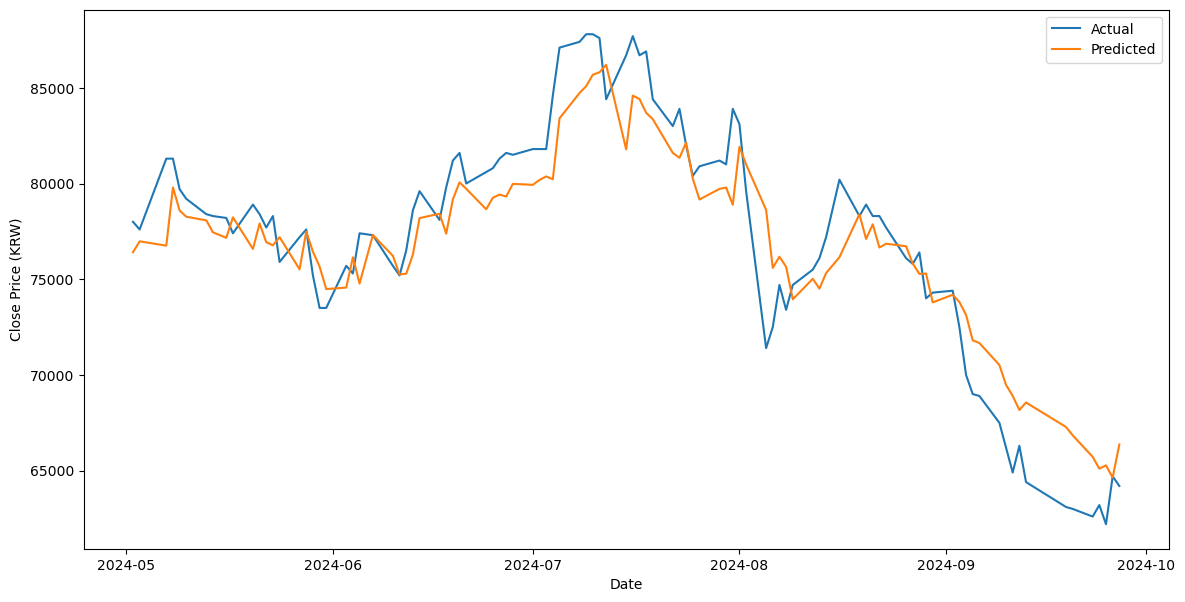

In [27]:
import matplotlib.pyplot as plt

# 최근 100일의 예측 결과 시각화
plt.figure(figsize=(14, 7))
plt.plot(test_seq_dates[-100:], actual_denormalized[-100:], label='Actual')
plt.plot(test_seq_dates[-100:], predicted_denormalized[-100:], label='Predicted')
plt.xlabel('Date')
plt.ylabel('Close Price (KRW)')
# plt.title('Close Prediction')
plt.legend()
plt.show()

In [28]:
# 예측 함수 (다음 5일 예측)
def predict_future_prices(model, last_sequence, num_days):
    model.eval()
    predicted_prices = []
    sequence = last_sequence.copy()

    for _ in range(num_days):
        with torch.no_grad():
            input_seq = torch.FloatTensor(sequence).unsqueeze(0).to(DEVICE)
            predicted_price = model(input_seq).item()  # 다음날 종가 예측
            predicted_prices.append(predicted_price)

            # 새로운 예측값을 기존 시퀀스에 추가
            predicted_price_reshaped = np.array([[predicted_price] * sequence.shape[1]])  # 모든 피처에 대해 예측값을 동일하게 적용
            next_input = np.append(sequence[1:], predicted_price_reshaped, axis=0)  # 첫 번째 값을 제외하고 새로운 값 추가
            sequence = next_input

    return predicted_prices

# 학습된 모델로 테스트 데이터 이후의 5일간 주가 예측
last_sequence = x_test_tensor[-1].cpu().numpy()  # 테스트 데이터의 마지막 시퀀스 사용
predicted_next_5_days = predict_future_prices(model, last_sequence, num_days=5)

# 예측된 주가를 원래 값으로 변환
predicted_next_5_days = scaler_y.inverse_transform(np.array(predicted_next_5_days).reshape(-1, 1))

# 결과 출력
for i, price in enumerate(predicted_next_5_days, 1):
    print(f"Day {i}: {price[0]:.2f} KRW")

Day 1: 66364.49 KRW
Day 2: 66407.60 KRW
Day 3: 66002.81 KRW
Day 4: 65464.25 KRW
Day 5: 64870.89 KRW
